In [1]:
import pandas as pd 
from get_information_sprottenflotte import get_station_of_kiel
from get_most_common_routes import get_routes, get_most_common_routes_from_routes, get_only_the_most_taken_route, add_route
import plotly.express as px
import plotly.graph_objects as go
import plotly
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
 # Ignore error message.
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
clusters_df = pd.read_csv(r"./general_data/sf_attributes_clustered_kiel_per_day.csv")
clusters_df = clusters_df.drop(columns=["Unnamed: 0", "Frequency_of_Usage", "Avg_Number_of_Bikes", "Avg_Usage_of_Station",
                                        "Avg_Returning_Bike_of_Station", "Avg_Renting_Bike_of_Station", "name"])

sprottenflotte_data_df = pd.read_csv(r"./data/sprottenflotte_data.csv")
sprottenflotte_data_df = sprottenflotte_data_df.drop(columns=["is_installed", "is_renting", "is_returning"])
sprottenflotte_data_clusters_df = pd.merge(sprottenflotte_data_df, clusters_df, on="Station_ID")

# # get only the stations in Kiel
sprottenflotte_data_clusters_kiel_df = get_station_of_kiel(sprottenflotte_data_clusters_df)
sprottenflotte_data_clusters_kiel_df = sprottenflotte_data_clusters_kiel_df.drop(columns=["lat", "lon"])
sprottenflotte_data_clusters_kiel_df


,Station_ID,Number_of_Bikes,Number_of_Docks_Available,last_reported,last_update,Cluster
0,24371,23,78,1677792158,1677802253,0
1,24371,23,78,1677792158,1677802529,0
2,24371,23,78,1677792158,1677802835,0
3,24371,23,78,1677792158,1677803141,0
4,24371,23,78,1677792158,1677803445,0
...,...,...,...,...,...,...
365610,26355,1,24,1679242197,1679243114,2
365611,26355,1,24,1679242197,1679243389,2
365612,26355,1,24,1679242197,1679243697,2
365613,26355,1,24,1679242197,1679244002,2


To find common routes taken, we will first examine the clusters, that are frequently used. So we will look at the most used cluster 0 and the train station which is saved as cluster 3

In [4]:
sprottenflotte_cluster_2_1_kiel_df = sprottenflotte_data_clusters_kiel_df.loc[(sprottenflotte_data_clusters_kiel_df["Cluster"] == 3) |
                                                                                (sprottenflotte_data_clusters_kiel_df["Cluster"] == 0) ]
sprottenflotte_routing_df = sprottenflotte_cluster_2_1_kiel_df[["Station_ID", "Number_of_Bikes", "last_update"]]
sprottenflotte_routing_df

,Station_ID,Number_of_Bikes,last_update
0,24371,23,1677802253
1,24371,23,1677802529
2,24371,23,1677802835
3,24371,23,1677803141
4,24371,23,1677803445
...,...,...,...
190686,24382,1,1679243114
190687,24382,1,1679243389
190688,24382,1,1679243697
190689,24382,1,1679244002


In [ ]:
# get a "routing table" from the data
routes = get_routes(sprottenflotte_routing_df)
routes

Now we want to get the most common routes with the function get_most_common_routes.

In [6]:
most_common_routes_df  = get_most_common_routes_from_routes(routes)
most_common_routes_df

,start_station,end_station,weight,start_name,start_lat,start_lon,end_name,end_lat,end_lon
0,24371,24385,116,Anleger Reventlou,54.333833,10.152250,Dreiecksplatz,54.328528,10.134417
1,24371,24412,138,Anleger Reventlou,54.333833,10.152250,MELUND-Olympiahochhaus,54.355250,10.131611
2,24371,24376,149,Anleger Reventlou,54.333833,10.152250,Kirchhofallee,54.316194,10.120583
3,24371,24397,254,Anleger Reventlou,54.333833,10.152250,Hauptbahnhof,54.315972,10.132278
4,24371,24383,116,Anleger Reventlou,54.333833,10.152250,CAU Sportstätten,54.343444,10.111139
...,...,...,...,...,...,...,...,...,...
127,24382,24413,126,Wilhelmplatz,54.323583,10.122278,Bernhard-Minetti-Platz,54.337864,10.133126
128,24382,24381,96,Wilhelmplatz,54.323583,10.122278,Westring/Eckernförder Str.,54.328543,10.117925
129,24382,24399,86,Wilhelmplatz,54.323583,10.122278,Exerzierplatz,54.321583,10.128389
130,24382,24370,120,Wilhelmplatz,54.323583,10.122278,Alter Markt,54.322806,10.139472


Visualize the take routes.

In [7]:
# get the right information for the markers that will be placed on map
station_id_list = most_common_routes_df["start_station"].unique()
attributes = []
for station in station_id_list:
    attributes_df = most_common_routes_df.loc[most_common_routes_df["start_station"] == station]
    start_name = attributes_df.iloc[0]["start_name"]
    lat = attributes_df.iloc[0]["start_lat"]
    lon = attributes_df.iloc[0]["start_lon"]
    station_id = attributes_df.iloc[0]["start_station"] 
    attributes.append([station_id, start_name, lat, lon])

attributes_df = pd.DataFrame(attributes, columns=["station_id", "station", "lat", "lon"])
attributes_df





,station_id,station,lat,lon
0,24371,Anleger Reventlou,54.333833,10.152250
1,24385,Dreiecksplatz,54.328528,10.134417
2,24412,MELUND-Olympiahochhaus,54.355250,10.131611
3,24376,Kirchhofallee,54.316194,10.120583
4,24397,Hauptbahnhof,54.315972,10.132278
5,24383,CAU Sportstätten,54.343444,10.111139
6,24413,Bernhard-Minetti-Platz,54.337864,10.133126
7,24381,Westring/Eckernförder Str.,54.328543,10.117925
8,24399,Exerzierplatz,54.321583,10.128389
9,24370,Alter Markt,54.322806,10.139472


In [8]:
# get information to plot lines between the points
list_info_lon = []
list_info_lat = []
list_info_weight = []
for station in station_id_list:
    attributes_for_lines_df = most_common_routes_df.loc[most_common_routes_df["start_station"] == station]

    start_lat_list = attributes_for_lines_df["start_lat"].to_list()
    end_lat_list = attributes_for_lines_df["end_lat"].to_list()
    start_lon_list = attributes_for_lines_df["start_lon"].to_list()
    end_lon_list = attributes_for_lines_df["end_lon"].to_list()
    weight = attributes_for_lines_df["weight"].to_list()
    for i in range(len(start_lat_list)):
        list_info_lat.append([start_lat_list[i], end_lat_list[i]])
        list_info_lon.append([start_lon_list[i], end_lon_list[i]])
        list_info_weight.append(weight[i])


In [10]:
# access Token
mapbox_access_token = open(".mapbox_token").read()

pointer_name = attributes_df.station
pointer_lat = attributes_df.lat
pointer_lon = attributes_df.lon
list_of_colors = [(32,32,218), (198,48,149), (0,127,0), (255,255,0), (95,0,0), (95,95,95), (187,127,243), 
                  (187,193,243), (255,166,0), (185,103,0), (56,26,136), (56,104,136), (232,104,136), (232,162,232)] 

fig = go.Figure()
j = 0

for station in station_id_list:
    start_lat_list, end_lat_list, start_lon_list, end_lon_list, weight, name = add_route(most_common_routes_df, station)
    weight_max = max(weight)

    # Create a plotly map and add the station points to the map
    for i in range(len(start_lat_list)):
        if i == 0:
            fig.add_trace(go.Scattermapbox(
                mode = "lines",
                lat = [start_lat_list[i], end_lat_list[i]],
                lon = [start_lon_list[i], end_lon_list[i]],
                showlegend = True,
                legendgroup = "group" + str(j),
                #legendgrouptitle_text = "From" + ' ' + name[0],
                line = dict(color = 'rgba(%s,%s,%s,%s)' %(list_of_colors[j][0], list_of_colors[j][1], list_of_colors[j][2], 
                                                        (weight[i]/weight_max)), width = weight[i]*(6/weight_max)),
                name = name[0],
                )
            )
        else:
            fig.add_trace(go.Scattermapbox(
                mode = "lines",
                lat = [start_lat_list[i], end_lat_list[i]],
                lon = [start_lon_list[i], end_lon_list[i]],
                showlegend = False,
                legendgroup = "group" + str(j),
                line = dict(color = 'rgba(%s,%s,%s,%s)' %(list_of_colors[j][0], list_of_colors[j][1], list_of_colors[j][2], 
                                                        (weight[i]/weight_max)), width = weight[i]*(6/weight_max)),
                name = name[0],
                #visible = "legendonly"
                )
            )
        
        # create arrows and plot on map
        widh = 0.02  #2*widh is the width of the arrow base as triangle
        l = 0.0007 # the arrow length

        A = np.array([start_lon_list[i],start_lat_list[i]])
        B = np.array([end_lon_list[i], end_lat_list[i]])
        v = B-A
        w = v/np.linalg.norm(v)     
        u  =np.array([-v[1], v[0]])
        P = B-2*l*w
        P_2 = B-l*w
        S = P - widh*u
        T = P + widh*u

        fig.add_trace(go.Scattermapbox(lon = [S[0], T[0], P_2[0], S[0]], 
                                    lat = [S[1], T[1], P_2[1], S[1]], 
                                    mode = 'lines', 
                                    fill = 'toself', 
                                    fillcolor = 'rgba(%s,%s,%s,1)' %(list_of_colors[j][0], list_of_colors[j][1], list_of_colors[j][2]), 
                                    line_color = 'rgba(%s,%s,%s,1)' %(list_of_colors[j][0], list_of_colors[j][1], list_of_colors[j][2]),
                                    showlegend = False,
                                    hoverinfo = 'skip',
                                    legendgroup = "group" + str(j),
                                    ))
    j += 1

    

for i in range(len(pointer_lat)):
    fig.add_trace(go.Scattermapbox(
        lat = [pointer_lat[i]],
        lon = [pointer_lon[i]],
        mode = "markers",
        marker = {'size': 12, 'color': 'red'},
        hoverinfo = 'name',
        #text = pointer_name[i],
        showlegend = False,
        name = pointer_name[i]
    ))

fig.update_layout(
    #title = "Most common routes taken",
    autosize = True,
    hovermode = "closest",
    showlegend = True,
    mapbox = dict(
        accesstoken = mapbox_access_token,
        center = dict(
            lat = 54.334221,
            lon = 10.134417,             
            ),
        zoom = 12,
        style = "light"
        ),
    width = 950,
    height = 450,
    margin = dict(l=0, r=0, b=0, t=0),
    legend = dict(bordercolor='rgb(100,100,100)',
                                borderwidth=2,
                                x=0,
                                y=1)
)

#plotly.offline.plot(fig, filename=r"./web_application/src/html/plotly_routes/most_common_routes.html")
fig.show()



Now lets only look at the most taken routes.

In [12]:
# access Token
mapbox_access_token = open(".mapbox_token").read()

pointer_name = attributes_df.station
pointer_lat = attributes_df.lat
pointer_lon = attributes_df.lon
list_of_colors = [(32,32,218), (198,48,149), (0,127,0), (255,255,0), (95,0,0), (95,95,95), (187,127,243), 
                  (187,193,243), (255,166,0), (185,103,0), (56,26,136), (56,104,136), (232,104,136), (232,162,232)] 

fig = go.Figure()
j = 0
weight = [1, 0.6]

for station in station_id_list:
    start_lat_list, end_lat_list, start_lon_list, end_lon_list, station_name = get_only_the_most_taken_route(most_common_routes_df, station)

    for i in range(len(start_lat_list)):
        if i == 0:
            fig.add_trace(go.Scattermapbox(
                        mode = "lines",
                        lat = [start_lat_list[i], end_lat_list[i]],
                        lon = [start_lon_list[i], end_lon_list[i]],
                        showlegend = True,
                        line = dict(color = 'rgba(%s,%s,%s,%s)' %(list_of_colors[j][0], list_of_colors[j][1], list_of_colors[j][2], 
                                                                weight[i]), width = 3
                                    ),
                        legendgroup = "group" + str(j),
                        name = station_name[0],
                        )
            )
        else:   
            fig.add_trace(go.Scattermapbox(
                        mode = "lines",
                        lat = [start_lat_list[i], end_lat_list[i]],
                        lon = [start_lon_list[i], end_lon_list[i]],
                        showlegend = False,
                        line = dict(color = 'rgba(%s,%s,%s,%s)' %(list_of_colors[j][0], list_of_colors[j][1], list_of_colors[j][2], 
                                                                weight[i]), width = 3
                                    ),
                        legendgroup = "group" + str(j),
                        name = station_name[0],
                        )
            ) 

        # create arrows and plot on map
        widh = 0.02  #2*widh is the width of the arrow base as triangle
        l = 0.0007 # the arrow length

        A = np.array([start_lon_list[i],start_lat_list[i]])
        B = np.array([end_lon_list[i], end_lat_list[i]])
        v = B-A
        w = v/np.linalg.norm(v)     
        u  =np.array([-v[1], v[0]])
        P = B-2*l*w
        P_2 = B-l*w
        S = P - widh*u
        T = P + widh*u

        fig.add_trace(go.Scattermapbox(lon = [S[0], T[0], P_2[0], S[0]], 
                                    lat = [S[1], T[1], P_2[1], S[1]], 
                                    mode = 'lines', 
                                    fill = 'toself', 
                                    fillcolor = 'rgba(%s,%s,%s,1)' %(list_of_colors[j][0], list_of_colors[j][1], list_of_colors[j][2]), 
                                    line_color = 'rgba(%s,%s,%s,1)' %(list_of_colors[j][0], list_of_colors[j][1], list_of_colors[j][2]),
                                    showlegend = False,
                                    hoverinfo = 'skip',
                                    legendgroup = "group" + str(j),
                                    ))

    j += 1

for i in range(len(pointer_lat)):
    fig.add_trace(go.Scattermapbox(
        lat = [pointer_lat[i]],
        lon = [pointer_lon[i]],
        mode = "markers",
        marker = {'size': 12, 'color': 'red'},
        hoverinfo = 'name',
        showlegend = False,
        name = pointer_name[i]
    ))

fig.update_layout(
    #title = "Most common routes taken",
    autosize = True,
    hovermode = "closest",
    showlegend = True,
    mapbox = dict(
        accesstoken = mapbox_access_token,
        center = dict(
            lat = 54.334221,
            lon = 10.134417,             
            ),
        zoom = 12,
        style = "light"
        ),
    width = 950,
    height =  450,
    margin = dict(l=0, r=0, b=0, t=0),
    legend = dict(bordercolor='rgb(100,100,100)',
                                borderwidth=2,
                                x=0,
                                y=1)
)

#plotly.offline.plot(fig, filename=r"./web_application/src/html/plotly_routes/2_mos_taken_routes.html")
fig.show()



In [13]:
most_common_routes_df

,start_station,end_station,weight,start_name,start_lat,start_lon,end_name,end_lat,end_lon
0,24371,24385,116,Anleger Reventlou,54.333833,10.152250,Dreiecksplatz,54.328528,10.134417
1,24371,24412,138,Anleger Reventlou,54.333833,10.152250,MELUND-Olympiahochhaus,54.355250,10.131611
2,24371,24376,149,Anleger Reventlou,54.333833,10.152250,Kirchhofallee,54.316194,10.120583
3,24371,24397,254,Anleger Reventlou,54.333833,10.152250,Hauptbahnhof,54.315972,10.132278
4,24371,24383,116,Anleger Reventlou,54.333833,10.152250,CAU Sportstätten,54.343444,10.111139
...,...,...,...,...,...,...,...,...,...
127,24382,24413,126,Wilhelmplatz,54.323583,10.122278,Bernhard-Minetti-Platz,54.337864,10.133126
128,24382,24381,96,Wilhelmplatz,54.323583,10.122278,Westring/Eckernförder Str.,54.328543,10.117925
129,24382,24399,86,Wilhelmplatz,54.323583,10.122278,Exerzierplatz,54.321583,10.128389
130,24382,24370,120,Wilhelmplatz,54.323583,10.122278,Alter Markt,54.322806,10.139472


In [14]:
station_id_list = most_common_routes_df["start_station"].unique()
weight = most_common_routes_df["weight"].to_list()


id_to_index = {}
index = 0
for id in station_id_list:
    id_to_index[id] = index
    index += 1

adjacency_matrix = []
index_weight = 0

for row in range(len(station_id_list)):
    row = []
    for col in range(len(station_id_list) - 1):
        row.append(weight[index_weight])
        index_weight += 1
    adjacency_matrix.append(row)

# add 0 at the diagonal (distance from the same station)
for row in range(len(station_id_list)):
    for col in range(len(station_id_list) - 1):
        if row == col:
            adjacency_matrix[row][col:col] = [0]
adjacency_matrix[row][col + 1:] = [0]
adjacency_matrix


[[0, 116, 138, 149, 254, 116, 155, 126, 106, 152, 149, 142],
 [103, 0, 85, 114, 169, 75, 101, 87, 80, 91, 106, 100],
 [95, 83, 0, 74, 124, 60, 87, 79, 67, 81, 77, 67],
 [142, 135, 101, 0, 199, 111, 124, 116, 101, 149, 116, 119],
 [264, 223, 183, 243, 0, 173, 235, 226, 153, 250, 196, 224],
 [97, 90, 79, 100, 135, 0, 87, 98, 64, 102, 94, 104],
 [126, 121, 99, 120, 170, 106, 0, 116, 91, 113, 100, 128],
 [102, 89, 74, 103, 169, 81, 113, 0, 71, 118, 106, 100],
 [82, 79, 62, 83, 139, 70, 105, 72, 0, 80, 89, 83],
 [95, 99, 87, 126, 186, 79, 119, 106, 82, 0, 103, 124],
 [114, 108, 74, 114, 181, 100, 106, 115, 69, 101, 0, 103],
 [120, 115, 90, 114, 184, 111, 126, 96, 86, 120, 111, 0]]

In [15]:
station_names = most_common_routes_df["start_name"].unique()

adjacency_matrix_df = pd.DataFrame(adjacency_matrix, columns=[station_names], index=station_names)
adjacency_matrix_df


,Anleger Reventlou,Dreiecksplatz,MELUND-Olympiahochhaus,Kirchhofallee,Hauptbahnhof,CAU Sportstätten,Bernhard-Minetti-Platz,Westring/Eckernförder Str.,Exerzierplatz,Alter Markt,Blücherplatz,Wilhelmplatz
Anleger Reventlou,0,116,138,149,254,116,155,126,106,152,149,142
Dreiecksplatz,103,0,85,114,169,75,101,87,80,91,106,100
MELUND-Olympiahochhaus,95,83,0,74,124,60,87,79,67,81,77,67
Kirchhofallee,142,135,101,0,199,111,124,116,101,149,116,119
Hauptbahnhof,264,223,183,243,0,173,235,226,153,250,196,224
CAU Sportstätten,97,90,79,100,135,0,87,98,64,102,94,104
Bernhard-Minetti-Platz,126,121,99,120,170,106,0,116,91,113,100,128
Westring/Eckernförder Str.,102,89,74,103,169,81,113,0,71,118,106,100
Exerzierplatz,82,79,62,83,139,70,105,72,0,80,89,83
Alter Markt,95,99,87,126,186,79,119,106,82,0,103,124


Plot the adjacency matrix as a heatmap

Text(0.5, 23.52222222222222, '')

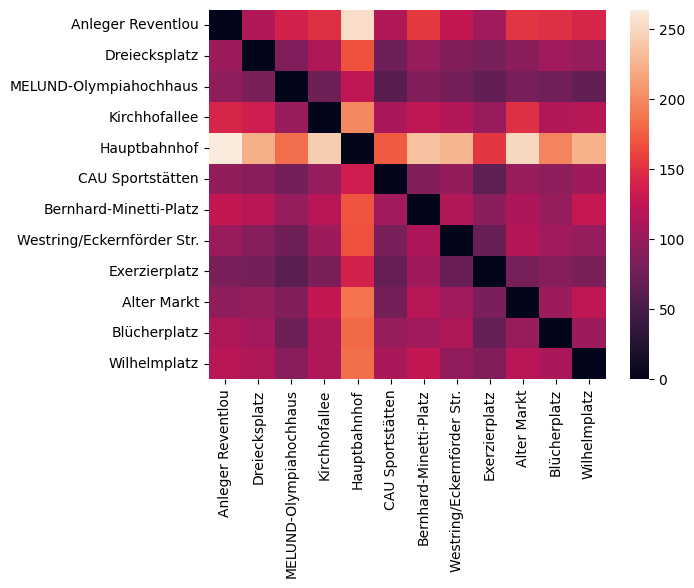

In [16]:
ax = plt.axes()
sns.heatmap(adjacency_matrix_df, ax = ax)
plt.xlabel("")


In [17]:
nodes = adjacency_matrix_df.index.values.tolist()

# add nodes
G = nx.DiGraph()
G.add_nodes_from(nodes)

# add weights
for row in range(len(adjacency_matrix[0])):
    for col in range(len(adjacency_matrix)):
        if not (row == col):
            G.add_edge(nodes[row], nodes[col], weight=adjacency_matrix[row][col])

# PageRanking
pagerank = nx.pagerank(G, alpha=1, max_iter=100, tol=1e-06, nstart=None, weight='weight')
pagerank



{'Anleger Reventlou': 0.08764232540969527,
 'Dreiecksplatz': 0.08059953769310213,
 'MELUND-Olympiahochhaus': 0.06818707062094756,
 'Kirchhofallee': 0.08688516791975961,
 'Hauptbahnhof': 0.12715022997463518,
 'CAU Sportstätten': 0.06973406995533439,
 'Bernhard-Minetti-Platz': 0.08737494909156614,
 'Westring/Eckernförder Str.': 0.0793330792414101,
 'Exerzierplatz': 0.06274502264638566,
 'Alter Markt': 0.08644758440612553,
 'Blücherplatz': 0.08041981108674837,
 'Wilhelmplatz': 0.08348115195429014}

Create Dataframe with the new gained informations to visualize the pagerank

In [18]:
stations_list = most_common_routes_df["start_name"].unique()
lat_list = most_common_routes_df["start_lat"].unique()
lon_list = most_common_routes_df["start_lon"].unique()

list_for_df = []
index = 0
while index < len(stations_list):
    list_for_df.append([stations_list[index], lat_list[index], lon_list[index], pagerank[stations_list[index]]])
    index += 1
pg_df = pd.DataFrame(list_for_df, columns=["station", "lat", "lon", "ranked"])


pg_lot_df = pg_df.loc[pg_df["ranked"] > 0.085]
pg_low_df = pg_df.loc[pg_df["ranked"] < 0.085]

print(pg_lot_df)
pg_low_df



                  station        lat        lon    ranked
0       Anleger Reventlou  54.333833  10.152250  0.087642
3           Kirchhofallee  54.316194  10.120583  0.086885
4            Hauptbahnhof  54.315972  10.132278  0.127150
6  Bernhard-Minetti-Platz  54.337864  10.133126  0.087375
9             Alter Markt  54.322806  10.139472  0.086448


,station,lat,lon,ranked
1,Dreiecksplatz,54.328528,10.134417,0.080600
2,MELUND-Olympiahochhaus,54.355250,10.131611,0.068187
5,CAU Sportstätten,54.343444,10.111139,0.069734
7,Westring/Eckernförder Str.,54.328543,10.117925,0.079333
8,Exerzierplatz,54.321583,10.128389,0.062745
10,Blücherplatz,54.341722,10.136861,0.080420
11,Wilhelmplatz,54.323583,10.122278,0.083481


In [19]:
# access Token
mapbox_access_token = open(".mapbox_token").read()

# Create a plotly map and add the station points to the map
fig = go.Figure()

fig = go.Figure()
j = 0
weight = [1, 0.6]

for station in station_id_list:
    start_lat_list, end_lat_list, start_lon_list, end_lon_list, station_name = get_only_the_most_taken_route(most_common_routes_df, station)

    for i in range(len(start_lat_list)):
        if i == 0:
            fig.add_trace(go.Scattermapbox(
                        mode = "lines",
                        lat = [start_lat_list[i], end_lat_list[i]],
                        lon = [start_lon_list[i], end_lon_list[i]],
                        showlegend = False,
                        line = dict(color = 'rgba(%s,%s,%s,%s)' %(list_of_colors[j][0], list_of_colors[j][1], list_of_colors[j][2], 
                                                                weight[i]), width = 3
                                    ),
                        legendgroup = "group" + str(j),
                        name = station_name[0],
                        )
            )
        else:   
            fig.add_trace(go.Scattermapbox(
                        mode = "lines",
                        lat = [start_lat_list[i], end_lat_list[i]],
                        lon = [start_lon_list[i], end_lon_list[i]],
                        showlegend = False,
                        line = dict(color = 'rgba(%s,%s,%s,%s)' %(list_of_colors[j][0], list_of_colors[j][1], list_of_colors[j][2], 
                                                                weight[i]), width = 3
                                    ),
                        legendgroup = "group" + str(j),
                        name = station_name[0],
                        )
            ) 
    j += 1

# add stations with more pg ranking
fig.add_trace(go.Scattermapbox(
    lat = pg_lot_df.lat,
    lon = pg_lot_df.lon,
    mode = "markers",
    marker = {'size': 500*pg_lot_df.ranked, 'color': '#FF6347', 'opacity': 1},    
    #hoverinfo = 'text',
    text = pg_lot_df.station,
    name = "More important",
    customdata = pg_lot_df.ranked,
    hovertemplate = 'Station name: %{text}'
                    + '<br>PageRank: %{customdata}',
    showlegend = True
    )
)

# add stations with lower pg ranking
fig.add_trace(go.Scattermapbox(
    lat = pg_low_df.lat,
    lon = pg_low_df.lon,
    mode = "markers",
    marker = {'size': 400*pg_low_df.ranked, 'color': '#4682B4', 'opacity': 1},
    #hoverinfo = 'text',
    text = pg_low_df.station,
    name = "Less important",
    customdata = pg_low_df.ranked,
    hovertemplate = 'Station name: %{text}'
                    + '<br>Frequency of Usage: %{customdata}',
   
    )
)


fig.update_layout(
    #title = "Most common routes taken",
    autosize = True,
    hovermode = "closest",
    showlegend = True,
    mapbox = dict(
        accesstoken = mapbox_access_token,
        center = dict(
            lat = 54.334221,
            lon = 10.134417,             
            ),
        zoom = 12,
        style = "light"
        ),
    width = 450,
    height = 450,
    margin = dict(l=0, r=0, b=0, t=0),
    legend = dict(bordercolor='rgb(100,100,100)',
                                borderwidth=2,
                                x=0,
                                y=1),
)

#plotly.offline.plot(fig, filename=r"./plotly_vis/test.html")
fig.show()
